In [98]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.utils.convert import from_networkx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler

In [99]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


def create_graphs(
    predictee, stocks, vis_col="close", window_size=30, step_size=1, purpose=""
):
    l = len(predictee)
    predict_frames = []
    predict_dates = predictee.index
    predict_values = predictee["close"].values
    stocks_frames = []
    targets = []

    for i in range(0, l, step_size):
        frames = []
        end = i + window_size
        if end > l:
            predict_frames.append(predictee[l - window_size - 1 : l - 1])
            targets.append(predict_values[l - 1])

            start_date = predict_dates[l - window_size - 1]
            end_date = predict_dates[l - 2]

            for stock in stocks:
                frame = stock[stock.index >= start_date]
                frame = frame[frame.index <= end_date]
                frames.append(frame)

            stocks_frames.append(frames)
            break

        predict_frames.append(predictee[i:end])
        targets.append(predict_values[end])

        start_date = predict_dates[i]
        end_date = predict_dates[end - 1]

        for stock in stocks:
            frame = stock[stock.index >= start_date]
            frame = frame[frame.index <= end_date]
            frames.append(frame)

        stocks_frames.append(frames)

    predict_edge_indexes = [
        from_networkx(nx.visibility_graph(frame[vis_col])).edge_index.to(torch.int64)
        for frame in predict_frames
    ]
    predict_frame_dates = [
        frame.index.strftime("%Y%m%d").astype(int).tolist() for frame in predict_frames
    ]
    stocks_edge_indexes = [
        [
            from_networkx(nx.visibility_graph(frame[vis_col])).edge_index.to(
                torch.int64
            )
            for frame in frames
        ]
        for frames in stocks_frames
    ]
    stocks_frames_dates = [
        [frame.index.strftime("%Y%m%d").astype(int).tolist() for frame in frames]
        for frames in stocks_frames
    ]

    graphs = []
    for i in range(len(predict_frames)):
        predict_x = torch.tensor(predict_frames[i].values, dtype=torch.float)
        predict_dates = torch.tensor(predict_frame_dates[i], dtype=torch.int)
        predict_edge_index = predict_edge_indexes[i]
        predict_graph = Data(
            x=predict_x, edge_index=predict_edge_index, dates=predict_dates
        )

        main_x = predict_x
        main_edge_index = predict_edge_index
        main_y = torch.tensor(targets[i], dtype=torch.float)
        offset = predict_graph.x.size(0)

        for j in range(len(stocks_frames[i])):
            stock_x = torch.tensor(stocks_frames[i][j].values, dtype=torch.float)
            stock_dates = torch.tensor(stocks_frames_dates[i][j], dtype=torch.int)
            stock_edge_index = stocks_edge_indexes[i][j]
            stock_graph = Data(
                x=stock_x, edge_index=stock_edge_index, dates=stock_dates
            )

            common_dates = torch.tensor(
                [date for date in predict_dates if date in stock_dates],
                dtype=torch.int,
            )

            new_edge_index = []
            for date in common_dates:
                nodes_in_predict = (predict_graph.dates == date).nonzero(as_tuple=True)[
                    0
                ]
                nodes_in_stock = (stock_graph.dates == date).nonzero(as_tuple=True)[0]

                for node1 in nodes_in_predict:
                    for node2 in nodes_in_stock:
                        new_edge_index.append([node1.item(), node2.item() + offset])

            new_edge_index = (
                torch.tensor(new_edge_index, dtype=torch.int).t().contiguous()
            )
            main_x = torch.cat([main_x, stock_graph.x], dim=0)

            main_edge_index = torch.cat(
                [main_edge_index, stock_graph.edge_index + offset, new_edge_index],
                dim=1,
            )
            offset += stock_graph.x.size(0)

        graphs.append(Data(x=main_x, edge_index=main_edge_index, y=main_y))

    torch.save(graphs, f"{purpose}_graphs.pt")
    return graphs


def prepare_stock(df, scaler):
    df = df.drop(columns=["status"])
    # df["per_change"] = df["per_change"].fillna(0)
    df["published_date"] = pd.to_datetime(df["published_date"])
    df.set_index("published_date", inplace=True)
    if df.isnull().values.any() or np.isinf(df.values).any():
        df = df.fillna(df.mean())
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(df.mean())
    og_index = df.index
    cols = df.columns
    data = scaler.fit_transform(df)
    df = pd.DataFrame(data, columns=cols, index=og_index)
    return df


def prepare_stocks(df, start_date, scaler):
    df = df.drop(columns=["status"])
    # df["per_change"] = df["per_change"].fillna(0)
    df["published_date"] = pd.to_datetime(df["published_date"])
    df.set_index("published_date", inplace=True)
    df = df[df.index >= start_date]
    if df.isnull().values.any() or np.isinf(df.values).any():
        df = df.fillna(df.mean())
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(df.mean())
    og_index = df.index
    cols = df.columns
    data = scaler.fit_transform(df)
    df = pd.DataFrame(data, columns=cols, index=og_index)
    return df

In [100]:
with open("stocks.json") as json_file:
    stock_paths = json.load(json_file)
    predict_path = stock_paths["predict"]
    other_paths = stock_paths["other"]

predictee = pd.read_csv(f"../data/{predict_path}")
stocks = [pd.read_csv(f"../data/{path}") for path in other_paths]

scaler = StandardScaler()

predictee = prepare_stock(predictee, scaler)
start_date = predictee.index[0]
stocks = [prepare_stocks(stock, start_date, scaler) for stock in stocks]

test_predictee = predictee[predictee.index >= "2024-09-22"]
cols = test_predictee.columns
test_stocks = [stock[stock.index >= "2024-09-22"] for stock in stocks]

test = create_graphs(
    test_predictee,
    test_stocks,
    vis_col="close",
    window_size=30,
    step_size=7,
    purpose="testing",
)
test_graphs = DataLoader(test, batch_size=1, shuffle=False)

In [101]:
model = GCN(7, 64 , 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('gcn.pth', map_location=device, weights_only=True))
model = model.to(device)

In [102]:
model.eval()
predictions = []
ground_truth = []
for batch in test_graphs:
    batch = batch.to(device)
    with torch.no_grad():
        output = model(batch.x, batch.edge_index, batch.batch)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)
predictions  = predictions.flatten().tolist()
ground_truth = ground_truth.flatten().tolist()

In [103]:
dates = pd.date_range(start="2024-09-22", end="2024-09-27")

In [104]:
prd = pd.DataFrame(columns=[cols])
prd_close = pd.Series(predictions)
prd['close'] = prd_close
prd = prd.fillna(0)
predictions = scaler.inverse_transform(prd)
predictions = pd.DataFrame(predictions, columns=[cols])
p_close = predictions['close'].values.flatten().tolist()

/tmp/ipykernel_8283/3272686237.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prd = prd.fillna(0)


In [105]:
gdt = pd.DataFrame(columns=[cols])
gdt_close = pd.Series(ground_truth)
gdt['close'] = gdt_close
gdt = gdt.fillna(0)
ground_truth = scaler.inverse_transform(gdt)
ground_truth = pd.DataFrame(ground_truth, columns=[cols])
g_close = ground_truth['close'].values.flatten().tolist()

/tmp/ipykernel_8283/648679643.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdt = gdt.fillna(0)


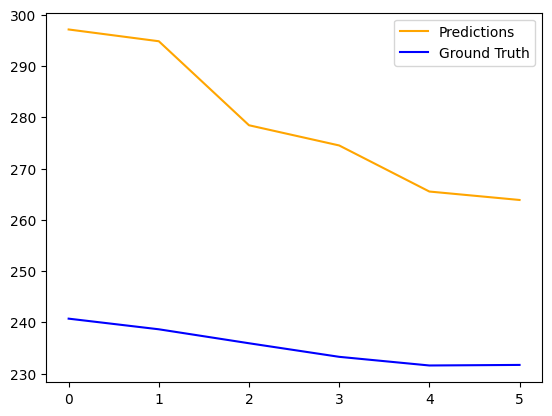

In [106]:
sns.lineplot(x=[0, 1, 2, 3, 4, 5], y=p_close, color="orange", label="Predictions")
sns.lineplot(x=[0, 1, 2, 3, 4, 5], y=g_close, color="blue", label="Ground Truth")
plt.show()